In [131]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr


sys.path.append(str(Path("../../..").resolve()))

from src.constants import model_data_dir

In [139]:
df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret", "year", "month", "day", "weekday"], axis=1)

dates = df_train.pop("Date")

## Explore ACF

In [141]:
auto_cor = [{"lag": lag, "corr": df_train["value_1d_fwd_rel_ret"].autocorr(lag)} for lag in range(1, 90)]
pd.DataFrame(auto_cor).sort_values("corr", ascending=False).head()

,lag,corr
19,20,0.056040
21,22,0.053327
12,13,0.051467
2,3,0.051342
15,16,0.046260


In [135]:
def cross_corr(df, target, col, lag):
    if col not in ["Date", "value_1d_fwd_rel_ret"]:
        try:
            return pearsonr(df[target][lag:], df[col].shift(lag)[lag:])[0]
        except:
            return np.nan
    
    return np.nan
            
def cross_corrs(df = df_train, target = "value_1d_fwd_rel_ret", lag = 1):
    corr_dict= {}
    for col in df.columns.tolist():
        corr_dict[col] = cross_corr(df, target, col, lag)
    return corr_dict

In [136]:
corrs = pd.DataFrame([cross_corrs(df_train, "value_1d_fwd_rel_ret", lag) 
                            for lag in range(1, 91)])
corrs

,VIX,V2X,MOVE,Gold Vol,JPM Global FX Vol,JPM G7 FX Vol,JPM EM FX Vol,EURUSD 1M Vol,USDJPY 1M Vol,USD Libor Swaption Vol,...,G10 Carry Trade Index,JPY/USD Carry,GBP/USD Carry,EUR/USD Carry,CAD/USD Carry,AUD/USD Carry,NZD/USD Carry,CHF/USD Carry,Copper 1 year carry,value_1d_fwd_rel_ret
0,-0.019411,-0.004223,-0.024694,-0.016416,-0.012649,-0.008441,-0.004263,-0.004608,0.013213,-0.020581,...,0.021209,0.010237,0.016688,0.009889,0.027998,0.020707,0.015681,-0.002378,0.004557,NaN
1,-0.012028,-0.012275,0.001459,-0.006600,-0.011206,-0.004087,-0.007821,0.000975,-0.001899,0.008874,...,0.017188,-0.016387,-0.000749,-0.016760,-0.004783,0.019999,0.012108,-0.018494,-0.019420,NaN
2,-0.008774,0.002550,0.012970,0.001613,-0.002493,0.012502,-0.041064,-0.004654,0.014170,0.015231,...,0.022060,-0.003296,-0.000079,0.028524,0.021939,0.024379,0.017578,0.003266,0.013814,NaN
3,-0.016930,0.011085,0.009311,-0.013749,0.022477,-0.005120,-0.008925,-0.013708,0.021090,-0.023458,...,-0.004998,0.019209,-0.045060,-0.024441,-0.010288,-0.022489,-0.007918,-0.007314,0.009551,NaN
4,0.003154,-0.013165,-0.000113,-0.004422,0.011273,0.014317,0.022262,0.001462,0.022878,0.005118,...,-0.012670,-0.017279,0.008178,0.011852,0.016089,0.026838,0.003994,0.025507,-0.006240,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.011599,-0.041722,-0.015895,-0.010896,-0.039916,-0.035555,-0.032611,-0.052852,-0.039878,-0.018562,...,0.013489,-0.011301,-0.039724,-0.006706,-0.002589,0.008716,-0.001641,0.005978,-0.008294,NaN
86,-0.015864,0.005506,-0.020954,0.007034,0.002402,-0.006522,-0.012215,-0.008707,0.014453,-0.002240,...,-0.049404,0.031229,0.000886,0.041992,0.047061,-0.008710,-0.011406,0.031405,-0.026963,NaN
87,-0.010239,0.000994,-0.001738,0.015345,0.004257,-0.007698,0.012429,-0.002053,-0.010815,-0.007950,...,-0.005035,-0.005797,-0.035365,-0.008015,0.002712,-0.020892,-0.013423,-0.006287,0.015855,NaN
88,0.024270,0.001180,-0.008582,-0.013947,-0.019935,-0.002794,0.014032,-0.027015,-0.007748,0.003387,...,-0.029860,-0.014520,-0.006226,-0.010065,-0.043365,-0.036597,-0.039062,-0.000768,-0.005638,NaN


## Feature selection

In [150]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

y_train, x_train = df_train.pop("value_1d_fwd_rel_ret"), df_train

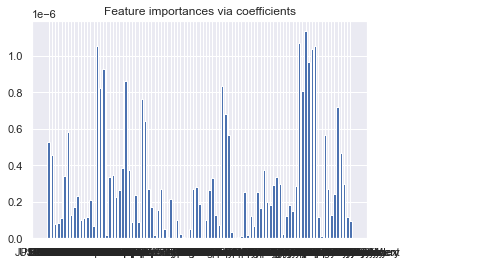

In [151]:
ridge_fit = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x_train, y_train)
importance = np.abs(ridge_fit.coef_)
feature_names = np.array(x_train.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

### Sequential selection

In [152]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
sfs_forward = SequentialFeatureSelector(
    ridge_fit, n_features_to_select=15, direction="forward"
).fit(x_train, y_train)

In [153]:
feature_names[sfs_forward.get_support()]

array(['MOVE', 'EURUSD 1M Vol', 'EURUSD Risk Reversal', 'MSCI EM', 'Gold',
       'Global Inflation-linked debt',
       'USGG3M   Index                                                  ',
       'GTCAD3MO Corp                                                   ',
       'GTFRF3MO Corp                                                   ',
       'GTJPY3MO Corp                                                   ',
       'EquityBond premia', 'University of Michigan Consumer Sentiment',
       'IWM', 'MSCI USA Momentum Index', 'MSCI USA Enhanced Value Index'],
      dtype=object)

### Feature selection based on importance

In [155]:
sfm = SelectFromModel(ridge_fit, threshold=np.sort(importance)[-15]).fit(x_train, y_train)
feature_names[sfm.get_support()]

array(['S&P 500', 'MSCI DM', 'MSCI EM', 'CDX IG 5Yr', 'Asian currency',
       'EM currency', 'High Yield Spread', 'JPM EMBI Global Spread',
       'Min Vol Index', 'IWF', 'IWM',
       'MSCI USA Sector Neutral Quality Index                                                  ',
       'MSCI USA Momentum Index', 'MSCI USA Enhanced Value Index',
       'CAD/USD Carry'], dtype=object)

## Prophet

In [156]:
from fbprophet import Prophet
selected_vars = feature_names[sfs_forward.get_support()]
m = Prophet(growth = "linear", weekly_seasonality=True, yearly_seasonality=True)


In [157]:
df_train["Date"] = dates
df_train["value_1d_fwd_rel_ret"] = y_train
df_model = df_train.rename(columns={"Date": "ds", "value_1d_fwd_rel_ret": "y"})

In [158]:
m.fit(df_model)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -41.4682


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5463.68   6.67321e-05       55.1494      0.1511           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       5463.73   6.23907e-05       58.7268   7.567e-07       0.001      201  LS failed, Hessian reset 
     176       5463.73   2.61644e-06       46.1082   3.852e-08       0.001      308  LS failed, Hessian reset 
     182       5463.73   3.60668e-07       62.0399      0.4506      0.4506      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [159]:
df_test = pd.read_csv(model_data_dir / "test_regression.csv")[["Date", "value_1d_fwd_rel_ret"] + selected_vars.tolist()].rename({"Date": "ds"}, axis=1)


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


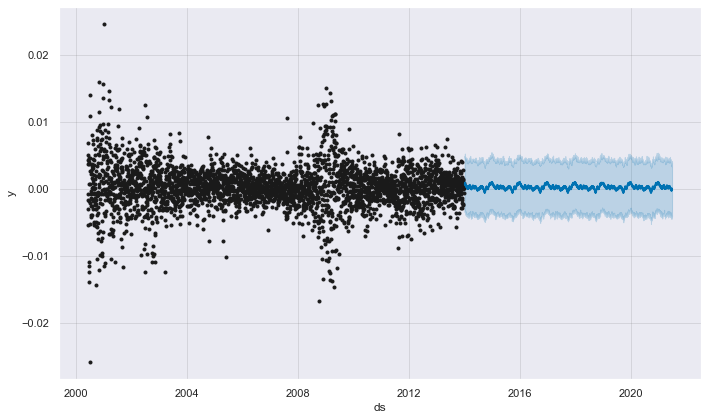

In [160]:
forecast = m.predict(df_test)
fig1 = m.plot(forecast)

<AxesSubplot:xlabel='ds', ylabel='price'>

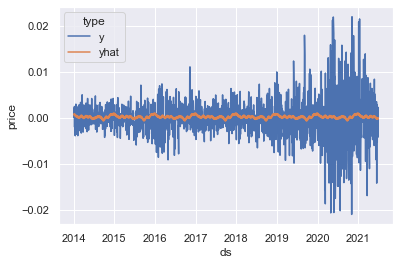

In [161]:
import seaborn as sns
sns.set_theme(style="darkgrid")

df_preds = forecast.assign(y = df_test["value_1d_fwd_rel_ret"])[["ds", "y", "yhat"]]
plot_data = df_preds.melt(id_vars="ds", var_name="type", value_name="price")

# Plot the responses for different events and regions
sns.lineplot(x="ds", y="price",
             hue="type",
             data=plot_data)

/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


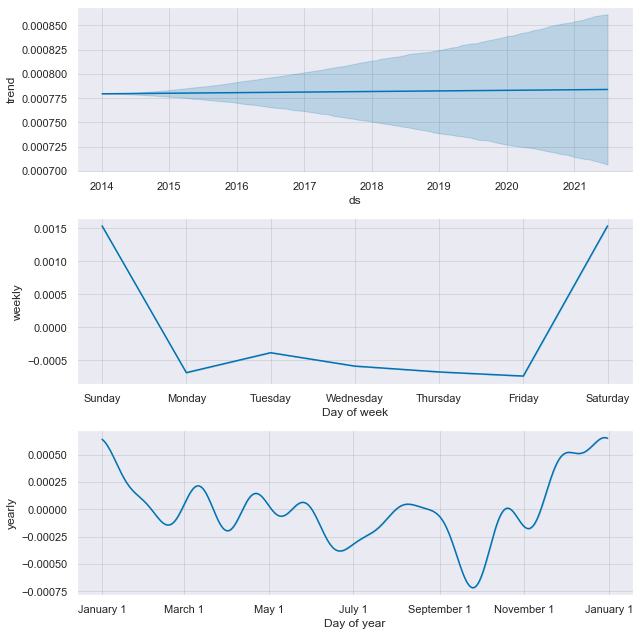

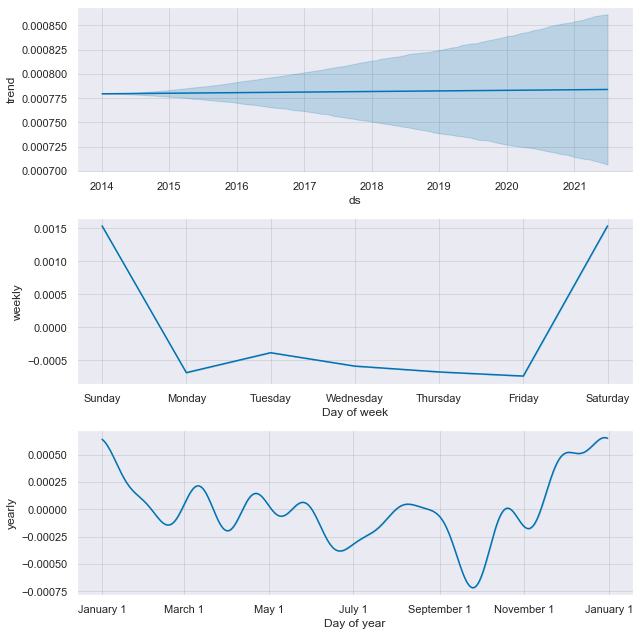

In [ ]:
m.plot_components(forecast)

In [ ]:
# mean absolute relative error
np.abs((df_preds["y"] - df_preds["yhat"])).mean()

0.0028299107324883475